Authors: Dror & Mariia

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from collections import Counter
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import time
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray')  #, linewidth=1)
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

## 1 First, let's see what data do we have

In [2]:
df = pd.read_csv('customer_segmentation.csv', encoding="ISO-8859-1") # from https://www.kaggle.com/carrie1/ecommerce-data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 2 EDA

### 2.1. 25% of entries are null-valued customers. 

So, let's select this subgroup, save it separately and later check it. Should it be removed from our main data? 

Yes, since we are dealing with clustering, these orders with undefined customers will be assigned to the same customer - this is bad. Probably, we will have to work with that data separately

In [4]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
null_customers = df[df.CustomerID.isna()]
null_customers.to_csv('null_customers.csv')  

Now, we will deal with data without NaNs:

In [6]:
# a few options
df1 = df.dropna(axis = 0, subset = ['CustomerID'])
df2 = df[~df.CustomerID.isna()] 
print(np.all(df1 == df2))
if np.all(df1 == df2):
    df = df1

True


### 2.2. Duplicates

In [7]:
print(f'The dataframe contains {df.duplicated().sum()} duplicated rows')

The dataframe contains 5225 duplicated rows


In [8]:
df = df1.drop_duplicates()
print('duplicates dropped')

duplicates dropped


In [9]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      401604 non-null object
StockCode      401604 non-null object
Description    401604 non-null object
Quantity       401604 non-null int64
InvoiceDate    401604 non-null datetime64[ns]
UnitPrice      401604 non-null float64
CustomerID     401604 non-null float64
Country        401604 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [10]:
df = df.reset_index()
if 'index' in df.columns:
    df = df.drop('index', axis=1)

### 2.3. Transform 'InvoiceDate' into some number of separate features

In [11]:
df['year'] = pd.DatetimeIndex(df['InvoiceDate']).year
df['month'] = pd.DatetimeIndex(df['InvoiceDate']).month
df['dayofweek'] = pd.DatetimeIndex(df['InvoiceDate']).dayofweek
df['weekofyear'] = pd.DatetimeIndex(df['InvoiceDate']).weekofyear
df['hour'] = pd.DatetimeIndex(df['InvoiceDate']).hour
df['dayofyear'] = pd.DatetimeIndex(df['InvoiceDate']).dayofyear

In [12]:
# let's see how many unique values for each column do we have
for col in df.columns:
    print(f'Column \'{col}\' has {len(np.unique(df[col]))} unique values')

Column 'InvoiceNo' has 22190 unique values
Column 'StockCode' has 3684 unique values
Column 'Description' has 3896 unique values
Column 'Quantity' has 436 unique values
Column 'InvoiceDate' has 20460 unique values
Column 'UnitPrice' has 620 unique values
Column 'CustomerID' has 4372 unique values
Column 'Country' has 37 unique values
Column 'year' has 2 unique values
Column 'month' has 12 unique values
Column 'dayofweek' has 6 unique values
Column 'weekofyear' has 51 unique values
Column 'hour' has 15 unique values
Column 'dayofyear' has 298 unique values


Regarding 6 days in a week :) probably, the orders are just not processed on some day of the week and hence moved to the next day

In [13]:
df.dayofweek.value_counts()  # hmmm, interesting

3    81575
2    69753
1    67376
0    65715
6    61673
4    55512
Name: dayofweek, dtype: int64

### 2.4. Transform 'Country' column into: 1. binary column (UK or not),   2. onehotencoded

In [14]:
# top 5 countries 
df.Country.value_counts(normalize=True)[:5]*100

United Kingdom    88.825809
Germany            2.360534
France             2.110288
EIRE               1.861286
Spain              0.629476
Name: Country, dtype: float64

Since we see that UK makes majority of rows, let's make boolean feature for UK/not UK too

In [15]:
df['is_UK'] = df.Country.apply(lambda x: int(x == 'United Kingdom'))
df_Countries = pd.get_dummies(df.Country)
df = pd.concat([df, df_Countries], axis=1)
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,...,0,0,0,0,0,0,0,0,1,0


### 2.5. Exploring 'Description' column

#### 2.5.1 vocabulary

In [16]:
# from collections import Counter

vocabulary = Counter({ word.lower(): 0 for descript in df.Description for word in descript.split() })
for descript in df.Description:
    words = [w.lower() for w in descript.split()]
    for word in words:
        if word in vocabulary:
            vocabulary[word] += 1

for place, (word, occurance) in enumerate(vocabulary.most_common(10)):
    print(f'{place + 1} - most popular word \'{word}\' occured {occurance} times')
print(f'The size of vocabulary: {len(vocabulary)}')

1 - most popular word 'set' occured 41053 times
2 - most popular word 'of' occured 40858 times
3 - most popular word 'bag' occured 38090 times
4 - most popular word 'red' occured 32254 times
5 - most popular word 'heart' occured 29047 times
6 - most popular word 'retrospot' occured 26754 times
7 - most popular word 'vintage' occured 25761 times
8 - most popular word 'design' occured 23663 times
9 - most popular word 'pink' occured 20264 times
10 - most popular word 'christmas' occured 19082 times
The size of vocabulary: 2242


#### 2.5.2 a bit of fun with wordcloud

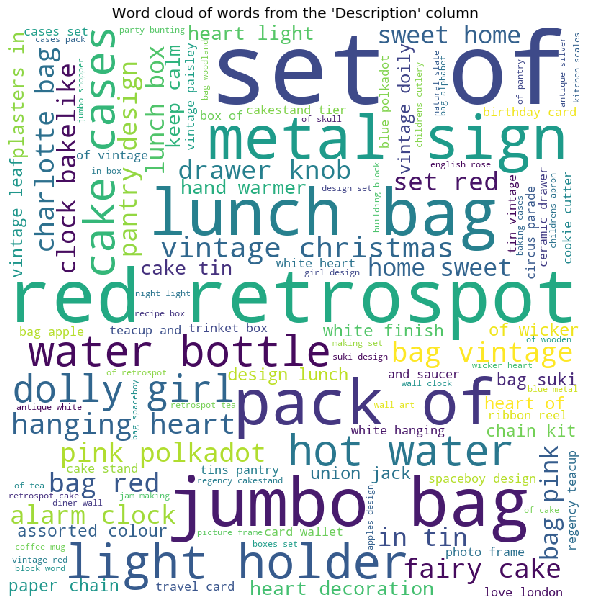

In [17]:
from wordcloud import WordCloud, STOPWORDS

all_words = [word.lower() for descr in df.Description for word in descr.split()]
stopwords = set(STOPWORDS)    

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(' '.join(all_words)) 
                         
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word cloud of words from the \'Description\' column')
plt.show() 

### 3. Cancelled orders

Cancelled orders have 'C' in InvoiceNo

In [18]:
df['order_cancelled'] = df['InvoiceNo'].apply(lambda x:int('C' in x))
pd.DataFrame(df.order_cancelled.value_counts(normalize=True)*100)

,order_cancelled
0,97.790859
1,2.209141


### 4 Total price of ordered unit

In [19]:
df['TotalPrice'] = df['UnitPrice'] * df['Quantity'] * (1 - df['order_cancelled'])
df.sort_values('TotalPrice', ascending=False)[:3]  # most expensive

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,year,month,...,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified,order_cancelled,TotalPrice
401131,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,2011,12,...,0,0,0,0,0,0,1,0,0,168469.6
37511,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011,1,...,0,0,0,0,0,0,1,0,0,77183.6
157405,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,2011,6,...,0,0,0,0,0,0,1,0,0,38970.0


### 5 Analysis & Plotting

In [20]:
def plot_graphs(col_x, col_y, func='sum', data=df):
    """Function that plots a barplot 
       Receives the column names of two variables and the function
       we want to use to group by on."""
    
    if func == 'sum':
        grouped_data = data.groupby([col_x])[col_y].sum().to_frame()
        title = f'sum of {col_y} by {col_x}'
        
    if func == 'mean':
        grouped_data = data.groupby([col_x])[col_y].mean().to_frame()
        title = f'average of {col_y} by {col_x}'
        
    grouped_data = grouped_data.reset_index().sort_values(by=col_y, ascending=False)
    
    f = plt.figure(figsize=(12, 6))
    sns.barplot(x=col_x,
                y=col_y,
                data=grouped_data.iloc[:10,:])
    plt.title(title);

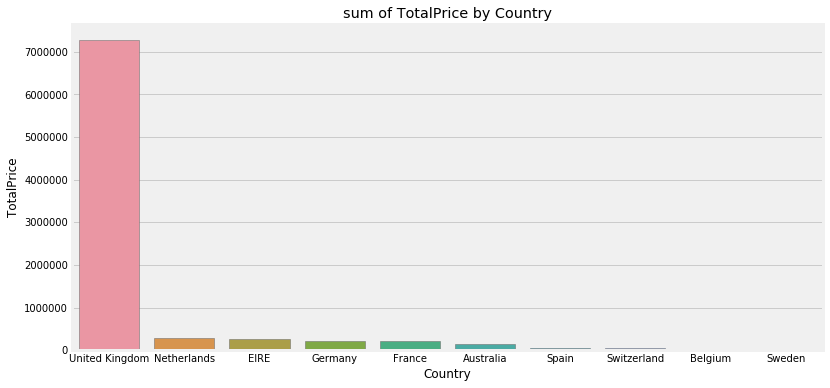

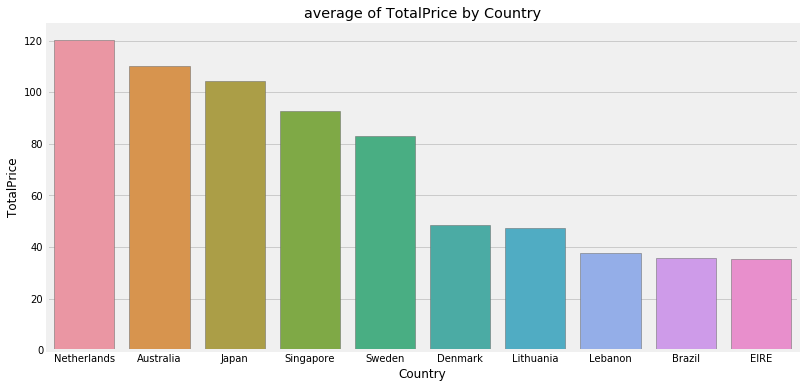

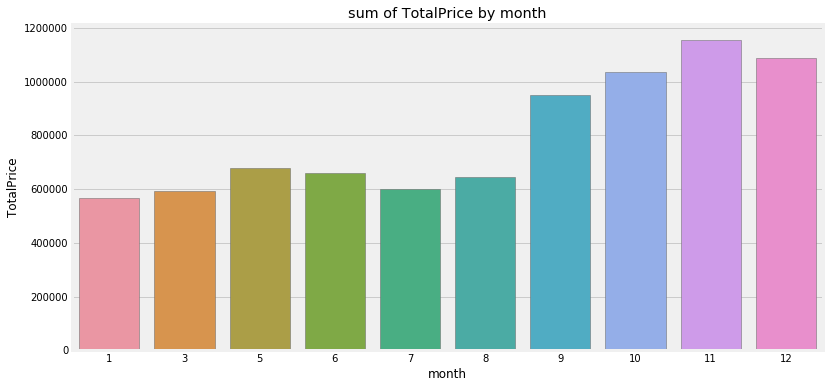

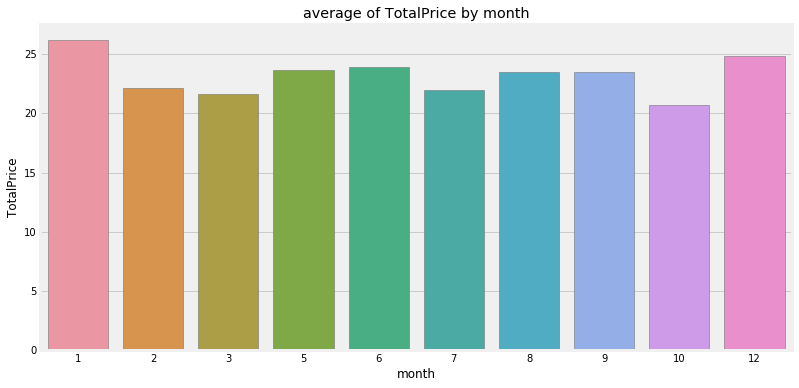

In [21]:
plot_graphs('Country', 'TotalPrice', data=df)
plot_graphs('Country', 'TotalPrice',func='mean', data=df)
plot_graphs('month', 'TotalPrice',func='sum', data=df)
plot_graphs('month', 'TotalPrice',func='mean', data=df)

In [22]:
temp = df[['InvoiceNo', 'StockCode', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'year', 'month', 'dayofweek',
       'weekofyear', 'hour', 'dayofyear', 'is_UK', 'order_cancelled', 'TotalPrice']]

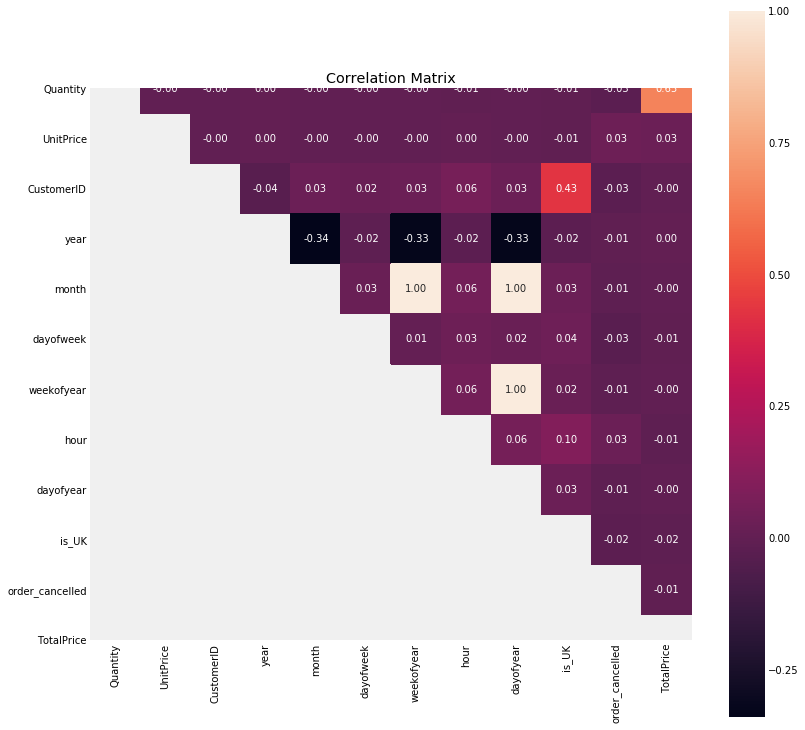

In [23]:
f = plt.figure(figsize=(12,13))
mask = np.tril(np.ones_like(temp.corr(), dtype=np.bool))
ax = sns.heatmap(temp.corr(), annot=True, fmt=".2f", mask = mask, square = True)
plt.title('Correlation Matrix')
plt.show();

Text(0.5, 1.0, 'Total price of 1 order per country')

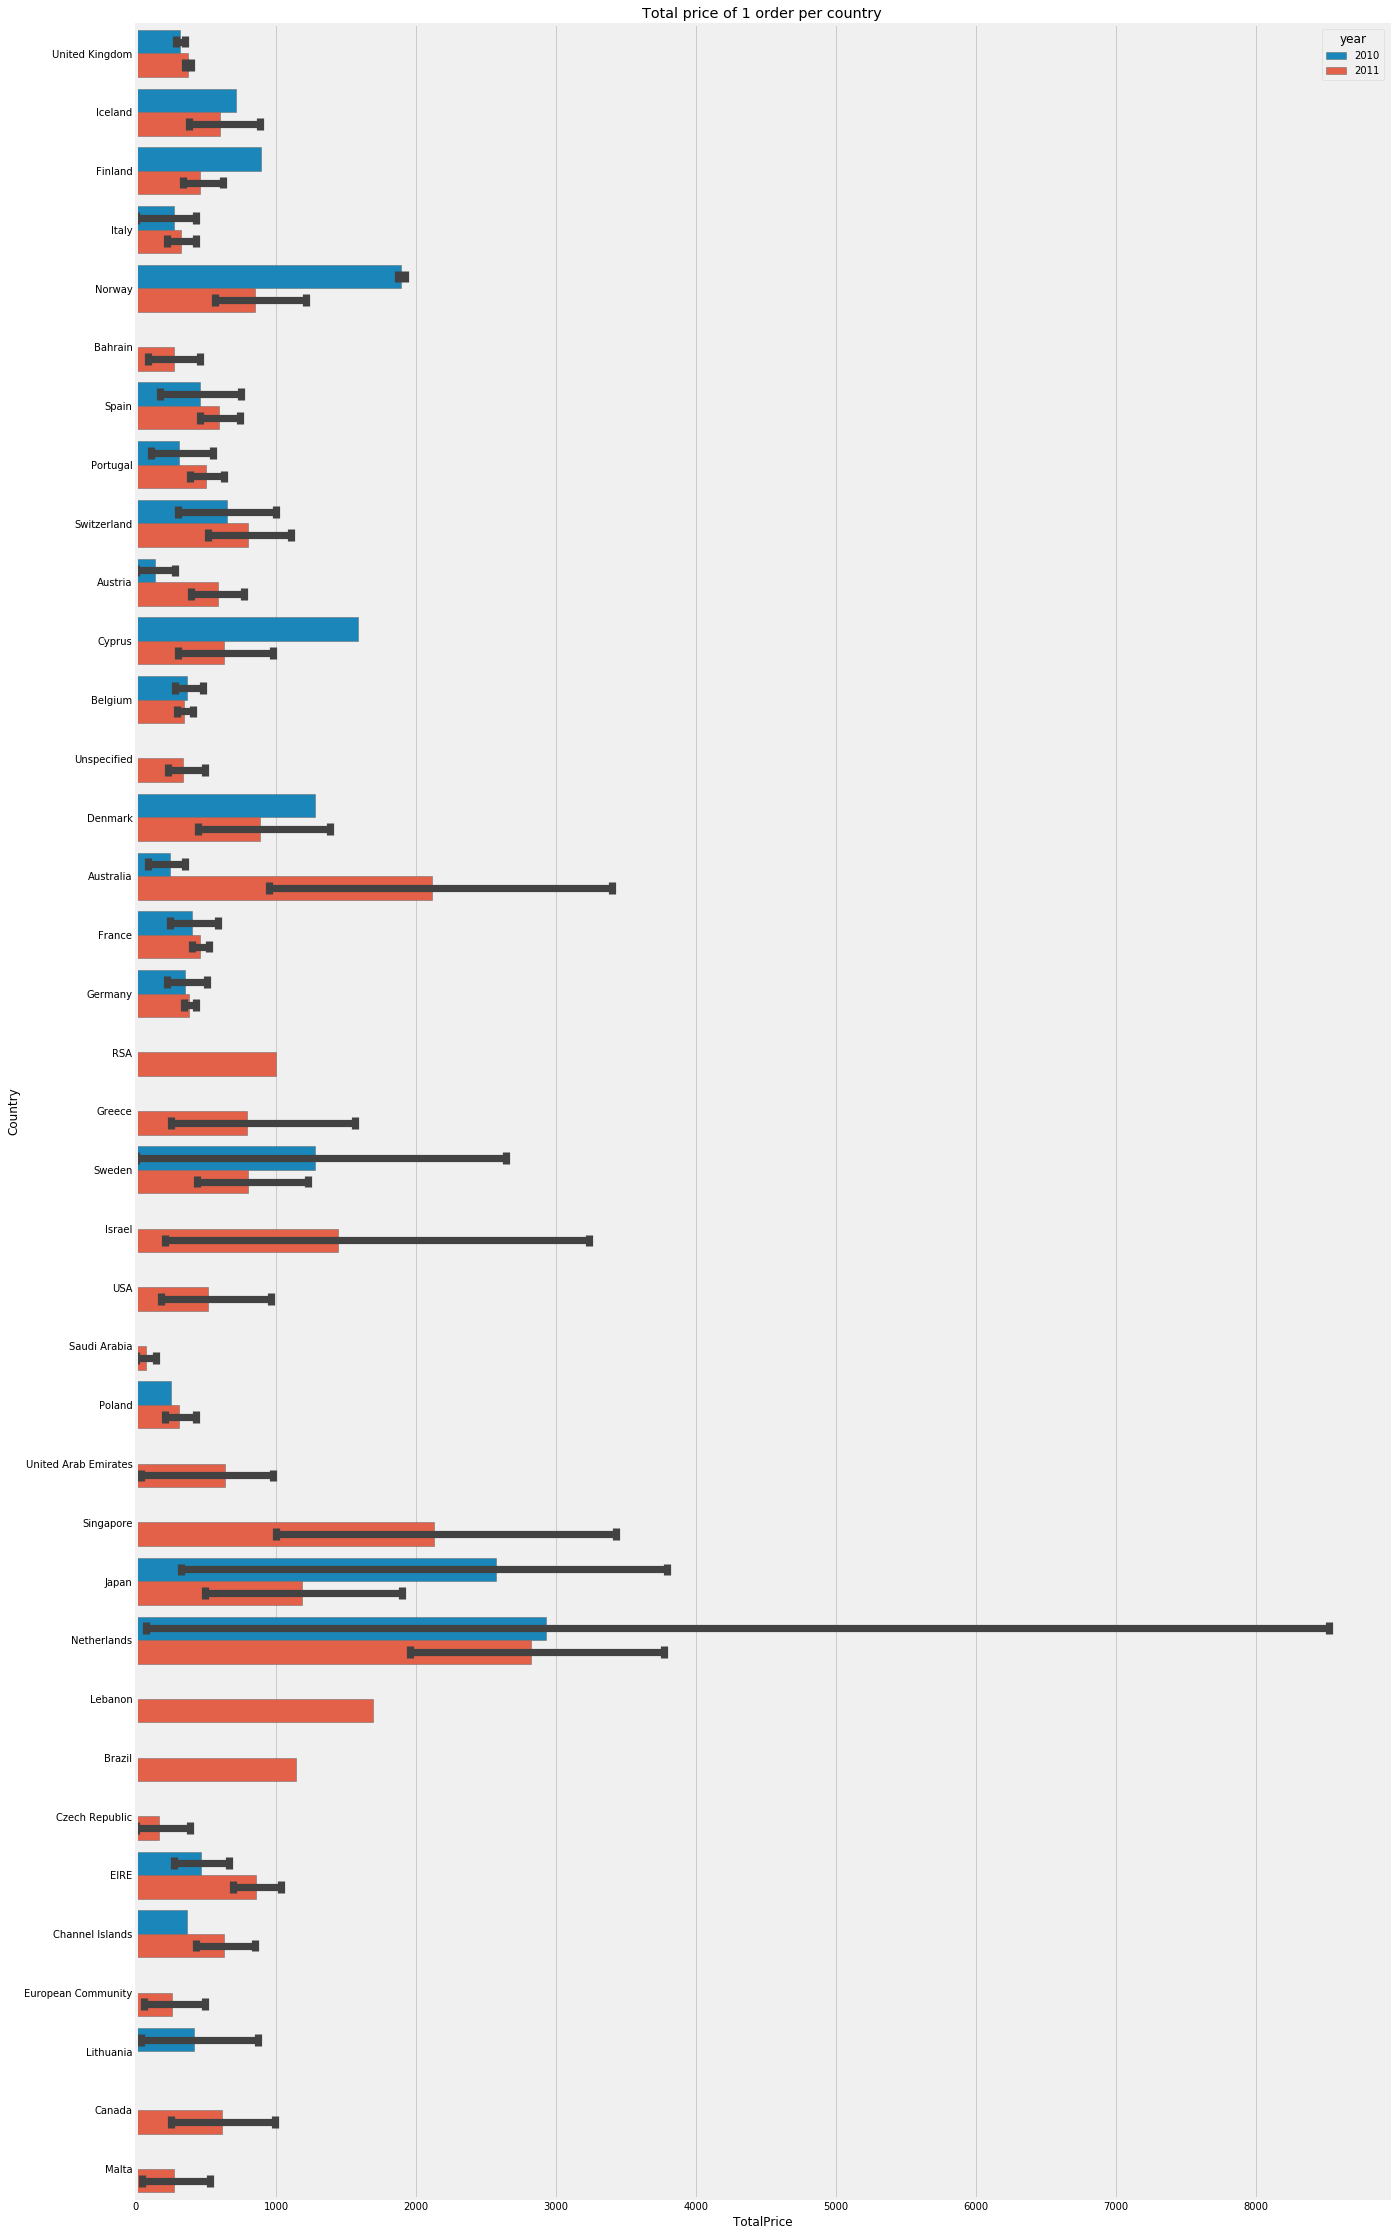

In [27]:
temp = df.groupby(by=['CustomerID', 'InvoiceNo', 'Country', 'year', 'dayofyear'], as_index=False)['TotalPrice'].sum()

plt.figure(figsize=(20 ,40))
sns.barplot(x="TotalPrice", y="Country", hue='year', data=temp, capsize=.2)
plt.title('Total price of 1 order per country')

### 6. Outliers

#### 6.1 Outliers by TotalPrice, UnitPrice or Quantity

In [28]:
i=5
for feature in ['UnitPrice', 'TotalPrice', 'Quantity']:
    highest_values = df.sort_values(by=feature, ascending=False)[feature][:i].to_list()
    lowest_values = df.sort_values(by=feature, ascending=False)[feature][-i:].to_list()
    print(f'In column {feature} {i} largest values: {highest_values}')
    print(f'and {i} smallest values: {lowest_values}\n')
    
df[['UnitPrice', 'TotalPrice', 'Quantity']].describe()

In column UnitPrice 5 largest values: [38970.0, 8142.75, 8142.75, 6930.0, 4287.63]
and 5 smallest values: [0.0, 0.0, 0.0, 0.0, 0.0]

In column TotalPrice 5 largest values: [168469.6, 77183.6, 38970.0, 8142.75, 7144.719999999999]
and 5 smallest values: [-0.0, -0.0, -0.0, -0.0, -0.0]

In column Quantity 5 largest values: [80995, 74215, 12540, 4800, 4300]
and 5 smallest values: [-2000, -3114, -9360, -74215, -80995]



,UnitPrice,TotalPrice,Quantity
count,401604.000000,401604.000000,401604.000000
mean,3.474064,22.129284,12.183273
std,69.764035,307.646110,250.283037
min,0.000000,-0.000000,-80995.000000
25%,1.250000,4.250000,2.000000
50%,1.950000,11.700000,5.000000
75%,3.750000,19.800000,12.000000
max,38970.000000,168469.600000,80995.000000


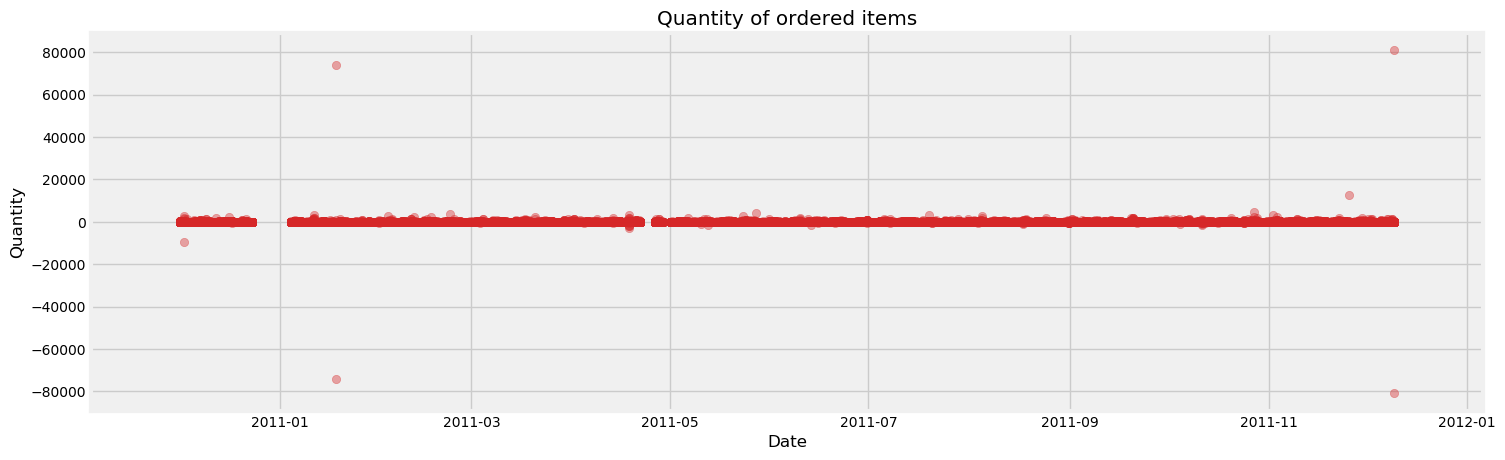

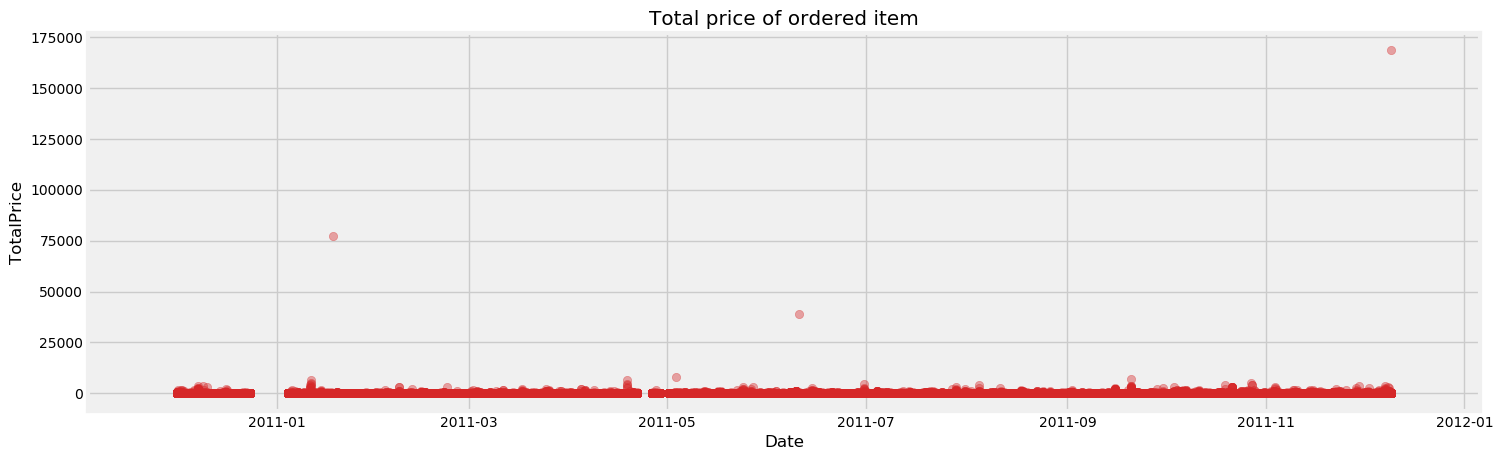

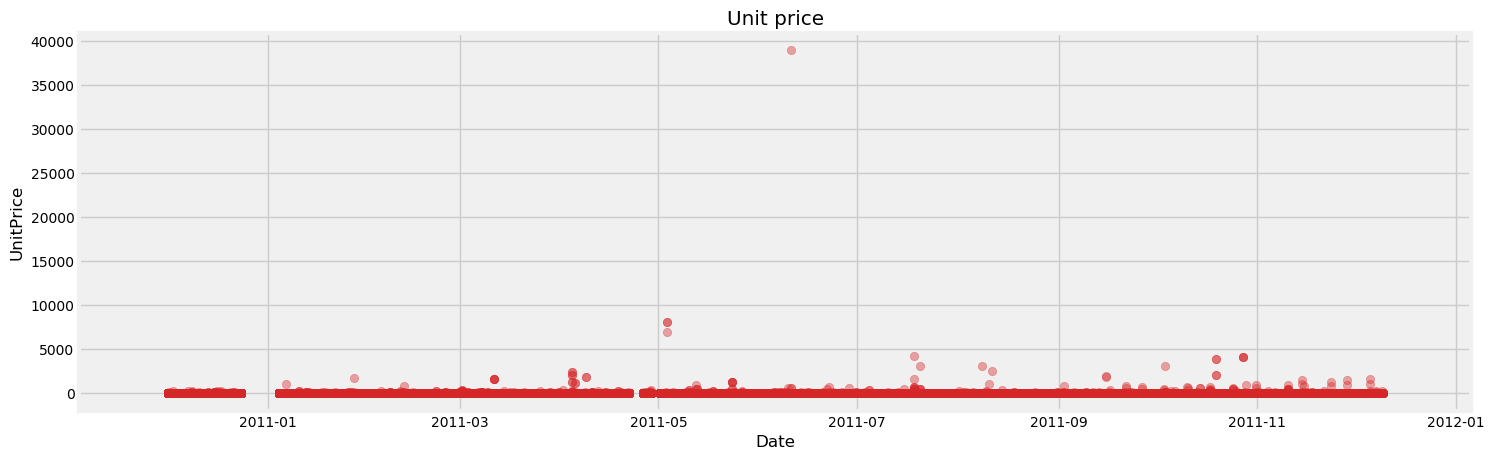

In [29]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='sth', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.scatter(x, y, color='tab:red', alpha=0.4)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.ylim()
    plt.show()

plot_df(df, x=df.InvoiceDate, y=df.Quantity, ylabel='Quantity', title='Quantity of ordered items')
plot_df(df, x=df.InvoiceDate, y=df.TotalPrice, ylabel='TotalPrice', title='Total price of ordered item')
plot_df(df, x=df.InvoiceDate, y=df.UnitPrice, ylabel='UnitPrice', title='Unit price')

We can detect outliers here:

    - in quantity of ordered items we see 2 cancelled orders (which give 4 symmetric points) with extremely high/low amount of ordered (probably, by mistake) products and other 2 points with -9k and +12k quantity
    
    - second plot with total price of ordered item shows both 2 main outliers mentioned above and 1 new outlier with extremely high unit price which yelds high total price
    
    - besides 1 previous outlier, we can see 2 more, but these 2 we will leave since it might be useful later

#### 6.2 Outliers by Country

In [30]:
rare_countries = []
for country in np.unique(df.Country):
    orders_from_country = df[df.Country==country]
    invno = 'InvoiceNo'
    how_many = len(orders_from_country.groupby([invno])[invno])
    if how_many < 5:
        print(f"from {country} got {how_many} orders")
        rare_countries.append(country)

from Bahrain got 2 orders
from Brazil got 1 orders
from Lebanon got 1 orders
from Lithuania got 4 orders
from RSA got 1 orders
from Saudi Arabia got 2 orders
from United Arab Emirates got 3 orders


So, let's remove 7 outliers from 6.1 and all rare countries from 6.2

In [31]:
before = len(df)
df = df[abs(df.Quantity) <= 9000]  # 9k is for leftmost point with negative quantity of items

for country in rare_countries:
    df = df[df.Country != country]
    
after = len(df)
print(f'Removed {before-after} rows')

Removed 271 rows


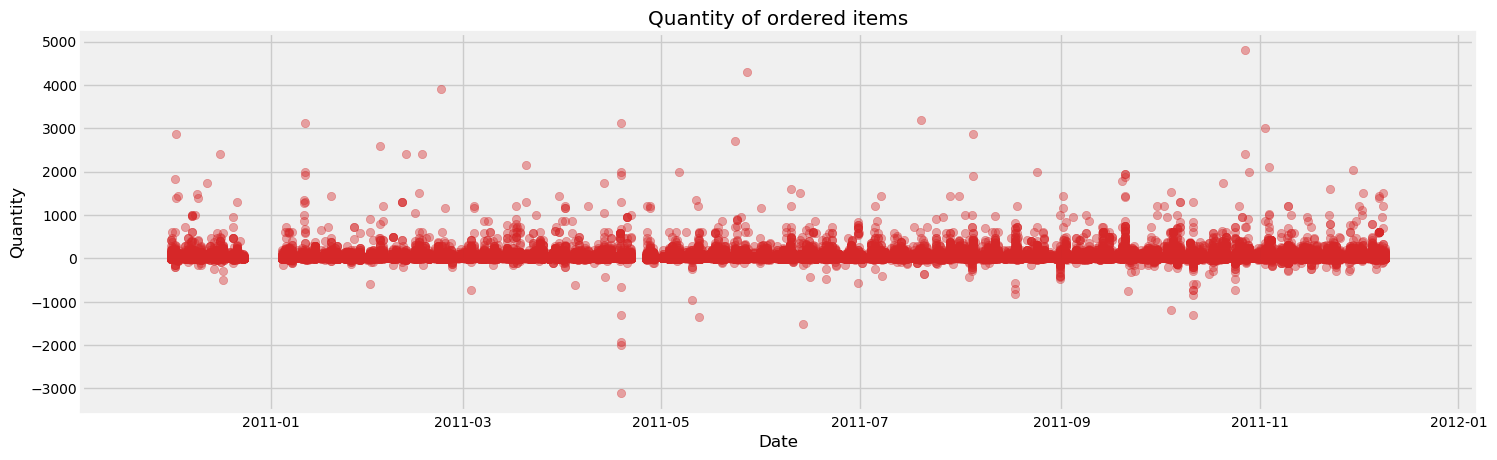

In [32]:
plot_df(df, x=df.InvoiceDate, y=df.Quantity, ylabel='Quantity', title='Quantity of ordered items')

In [34]:
# don't forget to drop dummy columns for rare countries since they will have only 0 now - rows with 1 were dropped
for country in rare_countries:
    df = df.drop(country, axis=1)

### 7. Feature engineering and splits

#### 7.1 Adding final basket price as sum of all TotalPrices in current order

In [35]:
tmp = df.groupby(by=['InvoiceNo'], as_index=False)['TotalPrice'].sum()
tmp = tmp.rename(columns = {'TotalPrice':'Basket_Price'})

def get_basket_from_invoice(tmp, invoice_num):
    """
    Gets final basket price from invoice number
    """
    invoice_num = str(invoice_num)
    return tmp[tmp.InvoiceNo == invoice_num].Basket_Price.values[0]

df['Basket_Price'] = df.apply(lambda row: get_basket_from_invoice(tmp, row['InvoiceNo']), axis=1)

#### 7.2 Before it goes too far, let's split the data to train and test in 2 ways: random and TS

In [36]:
# random split
from sklearn.model_selection import train_test_split

df_random_train, df_random_test = train_test_split(df, test_size=0.3, random_state=0)
print(f'Random split: train data has shape: {df_random_train.shape}, test of shape: {df_random_test.shape}')

Random split: train data has shape: (280933, 48), test of shape: (120400, 48)


In [37]:
df_ts_train = df[df.InvoiceDate <= datetime.date(2011, 10, 1)]
df_ts_test = df[df.InvoiceDate > datetime.date(2011, 10, 1)]
print(f'TS split: train data has shape: {df_ts_train.shape}, test of shape: {df_ts_test.shape}')

TS split: train data has shape: (269852, 48), test of shape: (131481, 48)


#### 7.3 Removing StockCode

 Since it's not quite clear how it can be useful

In [38]:
stcd = "StockCode"
print(f'StockCode column has type: {df.dtypes[stcd]} and {len(np.unique(df.StockCode))} unique values')
df = df.drop('StockCode', axis=1)

StockCode column has type: object and 3682 unique values


#### 7.4 Dealing with Description

**7.4.1 First, we should clean all data from stopwords, no need to do it separately on train and test**

In [39]:
from nltk.corpus import stopwords
from textblob import TextBlob
import re

def tokenize(s):
        """tokenizing"""
        return ' '.join(TextBlob(s).words)

def remove_stopwords(s):
    "remove nltk stopwords"
    return ' '.join([word for word in s.split() if word not in stopwords.words('english')])


def text_cleaning(s):
    """Aggregation of text cleaning functions"""
    
    s = tokenize(s)
    s = remove_stopwords(s)
    s = re.sub(r'\d+', '', s)
    return s


df['Description'] = df['Description'].apply(lambda s: text_cleaning(s))

**7.4.2 Explore the train data to decide which number of clusters is the best: we will use plots and elbow method to decide. Unfortunately, we can't use silhoutte score as it's computation is very time-consuming**

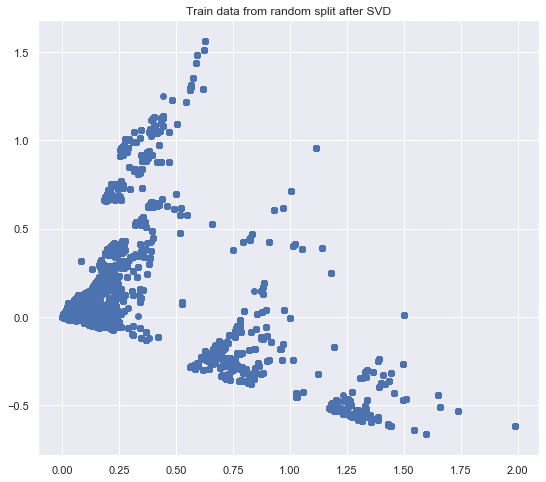

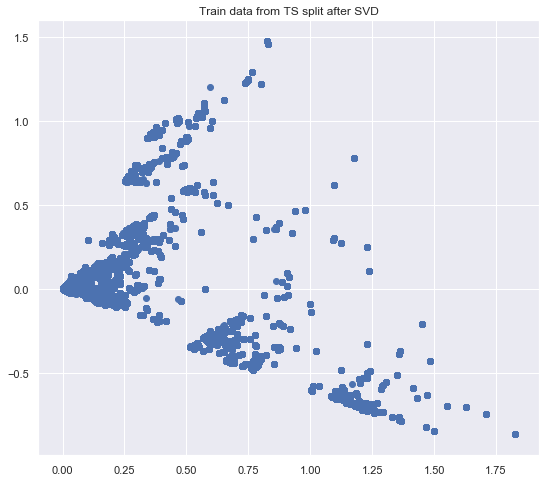

In [47]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_random = CountVectorizer(max_features=2000)
X_random_train = vectorizer_random.fit_transform(df_random_train['Description'])
X_random_test = vectorizer_random.transform(df_random_test['Description'])

vectorizer_ts = CountVectorizer(max_features=2000)
X_ts_train = vectorizer_ts.fit_transform(df_ts_train['Description'])
X_ts_test = vectorizer_ts.transform(df_ts_test['Description'])

svd_random = TruncatedSVD(n_components=2)
X_random_train_reduced = svd_random.fit_transform(X_random_train)
X_random_test_reduced = svd_random.transform(X_random_test)
f = plt.figure(figsize=(8,8))
plt.scatter(X_random_train_reduced[:,0], X_random_train_reduced[:, 1])
plt.title('Train data from random split after SVD')
plt.show()


svd_ts = TruncatedSVD(n_components=2)
X_ts_train_reduced = svd_ts.fit_transform(X_ts_train)
X_ts_test_reduced = svd_ts.transform(X_ts_test)
f = plt.figure(figsize=(8,8))
plt.scatter(X_ts_train_reduced[:,0], X_ts_train_reduced[:, 1])
plt.title('Train data from TS split after SVD')
plt.show()



Random split:
Number of clusters: 2, WCSS: 38613.07396952134
Number of clusters: 3, WCSS: 13102.855742226346
Number of clusters: 4, WCSS: 8552.560071260785
Number of clusters: 5, WCSS: 6028.791394947841
Number of clusters: 6, WCSS: 4866.248299444402
Number of clusters: 7, WCSS: 3828.0667875047725
Number of clusters: 8, WCSS: 3084.560067368376
Number of clusters: 9, WCSS: 2667.343119472739
Number of clusters: 10, WCSS: 2297.464500198198

TS split:
Number of clusters: 2, WCSS: 39427.33188256748
Number of clusters: 3, WCSS: 13116.641738513363
Number of clusters: 4, WCSS: 8842.624319696728
Number of clusters: 5, WCSS: 6319.979015404392
Number of clusters: 6, WCSS: 5123.581433867794
Number of clusters: 7, WCSS: 3915.5932356186227
Number of clusters: 8, WCSS: 3188.9974184102925
Number of clusters: 9, WCSS: 2742.102909988383
Number of clusters: 10, WCSS: 2325.243856656466


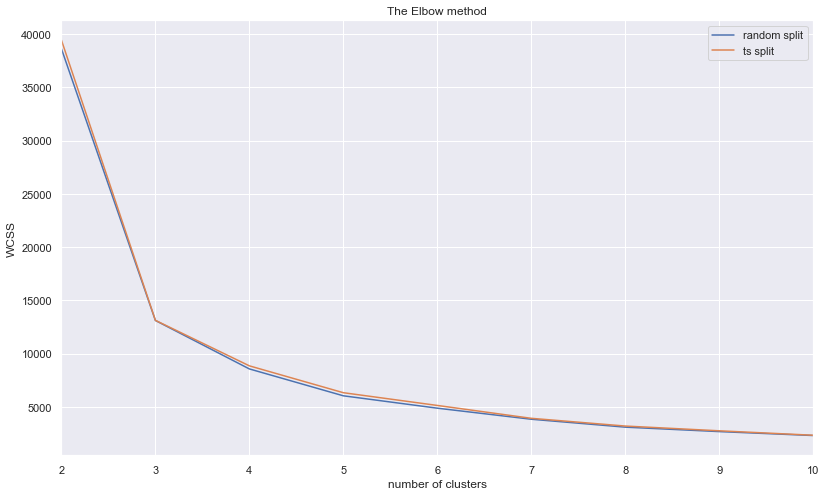

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns; sns.set()

# random split
kscores_random = {}
max_clusters = 10
print('Random split:')
for n in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters = n)
    clusters = kmeans.fit_predict(X_random_train_reduced)
    wcss = kmeans.inertia_
    kscores_random[n] = wcss
    print(f'Number of clusters: {n}, WCSS: {wcss}')
    
    
# ts split
print('\nTS split:')
kscores_ts = {}
max_clusters = 10

for n in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters = n)
    clusters = kmeans.fit_predict(X_ts_train_reduced)
    wcss = kmeans.inertia_
    kscores_ts[n] = wcss
    print(f'Number of clusters: {n}, WCSS: {wcss}')
    

f = plt.figure(figsize=(12,8))
plt.plot(list(kscores_random.keys()), list(kscores_random.values()), label='random split')
plt.plot(list(kscores_ts.keys()), list(kscores_ts.values()), label='ts split')
plt.xlim((2, max_clusters))
plt.title("The Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

Though elbow method suggests taking 3 as an optimal number of clusters, we prefer 4 since on the plot for X_reduced we can clearly see 4 clusters. Since these clusters are well separated we rely on this plot


Comment: with 2 components, we can see that we have 3 clusters. With 5 components, 6 looks to be more appropriate.

**7.4.3 Plotting the data with 4 clusters**

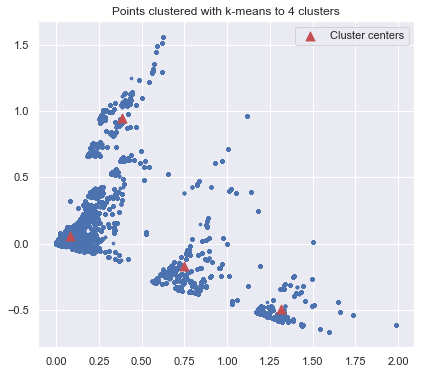

In [76]:
def cluster_and_plot(X_train_reduced, X_test_reduced, k, title='Points clustered with k-means', plotting=True):
    # pick random centers to be initial cluster centers
    initial_centers = X_train_reduced[np.random.randint(X_train_reduced.shape[0],size=k)]
    
    # cluster with k-means
    kmeans = KMeans(n_clusters = k)
    clusters = kmeans.fit_predict(X_train_reduced)
    centers = kmeans.cluster_centers_

    # plot the data-point and the new clusters
    if plotting:
        f = plt.figure(figsize=(6,6))
        plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], s=7)
        plt.scatter(centers[:,0], centers[:,1], marker='^', c='r', s=80, label='Cluster centers');
        plt.legend()
        plt.title(title);
    train_labels, test_labels = clusters, kmeans.predict(X_test_reduced)
    return train_labels, test_labels  


best_n_clusters=4
random_train_labels, random_test_labels = cluster_and_plot(X_random_train_reduced, X_random_test_reduced, best_n_clusters, f'Points clustered with k-means to {best_n_clusters} clusters')
ts_train_labels, ts_test_labels = cluster_and_plot(X_ts_train_reduced, X_ts_test_reduced, best_n_clusters,  f'Points clustered with k-means to {best_n_clusters} clusters', plotting=False)

In [90]:
df_random_train['desc_groups'] = random_train_labels 
df_random_test['desc_groups'] = random_test_labels 

df_ts_train['desc_groups'] = ts_train_labels 
df_ts_test['desc_groups'] = ts_test_labels 

In [175]:
# and the whole data

vectorizer = CountVectorizer(max_features=2000)
X = vectorizer_random.fit_transform(df['Description'])
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X)
kmeans = KMeans(n_clusters = 4)
clusters = kmeans.fit_predict(X_reduced)
df['desc_groups'] = clusters

**7.4.4 Wrapping it as class**

In [91]:
from sklearn.base import TransformerMixin, BaseEstimator


class ClusterizeDescription(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_clusters, vectorizer= CountVectorizer(max_features=2000), svd = TruncatedSVD(n_components=2)):
        self.n_clusters = n_clusters
        self.vectorizer = vectorizer
        self.svd = svd
        self.kmeans = KMeans(n_clusters = self.n_clusters)
            
            
            
    def fit_transform(self, train_data):
            X_train = self.vectorizer.fit_transform(train_data['Description'])
            X_train_reduced = self.svd.fit_transform(X_train)
            # cluster with k-means
            train_clusters = self.kmeans.fit_predict(X_train_reduced)
            centers = self.kmeans.cluster_centers_
            return train_clusters, X_train_reduced, centers
            

        
    def transform(self, test_data):
            X_test = self.vectorizer.transform(test_data['Description'])
            X_test_reduced = self.svd.transform(X_test)
            test_clusters = self.kmeans.predict(X_test_reduced)
            return test_clusters, X_test_reduced
            
            
    def cluster_and_plot(self, train_data, test_data, title='Points clustered with k-means', plotting=True):
        
        k = self.n_clusters
        train_clusters, X_train_reduced, centers = self.fit_transform(train_data)
        test_clusters, X_test_reduced = self.transform(test_data)
        
        # pick random centers to be initial cluster centers
        initial_centers = X_train_reduced[np.random.randint(X_train_reduced.shape[0],size=k)]
        
        # plot the data-point and the new clusters
        if plotting:
            f = plt.figure(figsize=(6,6))
            plt.scatter(X_train_reduced[:,0], X_train_reduced[:,1], s=7)
            plt.scatter(centers[:,0], centers[:,1], marker='^', c='r', s=80, label='Cluster centers');
            plt.legend()
            plt.title(title);
        
        return train_clusters, test_clusters  
            
            
            
clusterize_desc = ClusterizeDescription(4, CountVectorizer(max_features=2000), svd = TruncatedSVD(n_components=2))         

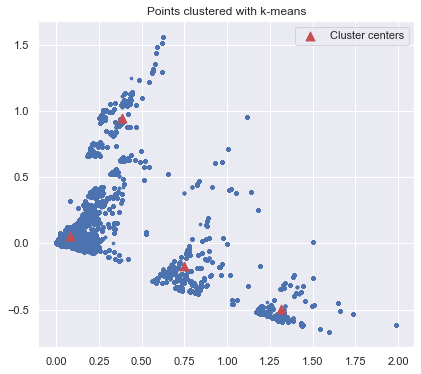

In [92]:
train_labels_r, test_labels_r =  clusterize_desc.cluster_and_plot(df_random_train, df_random_test)

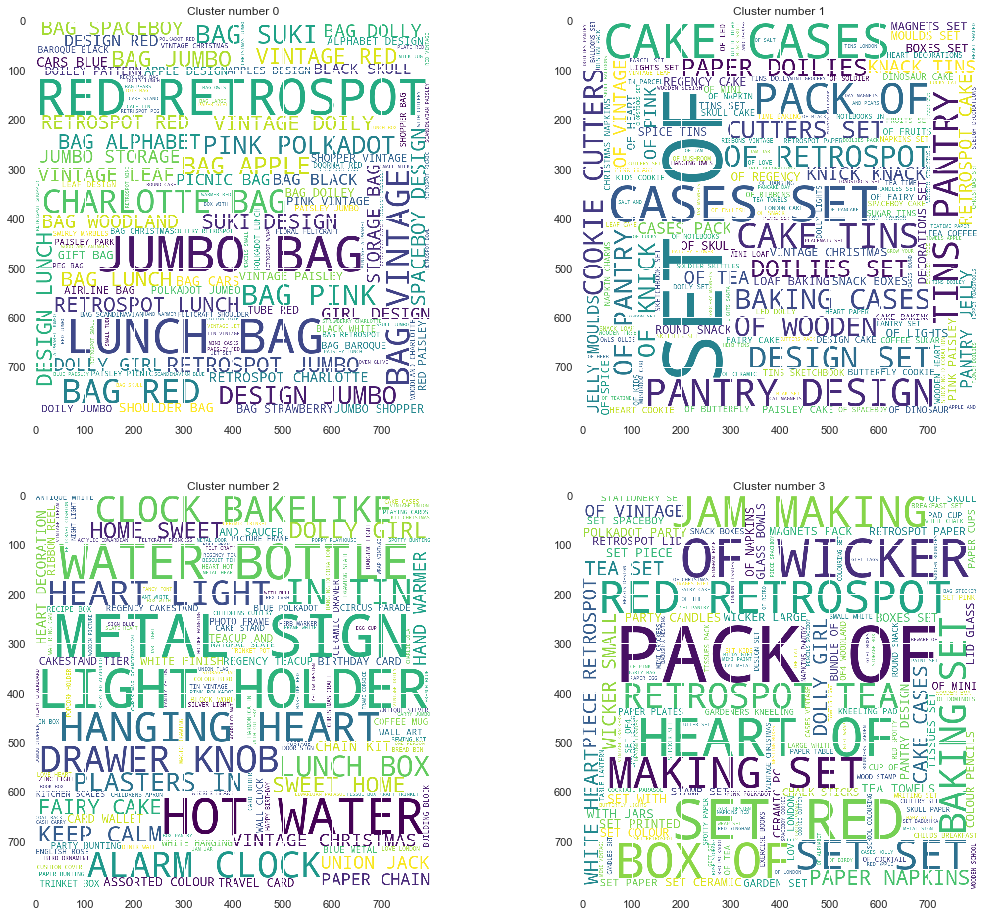

In [93]:
def wordcloud(all_words):
    """
    generates a wordcloud.
    Recevies a text to plot.
    """
    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(all_words) 
    return wordcloud

stopwords = set(STOPWORDS)  
num_clusters = len(set(df_random_train['desc_groups']))

_, axs = plt.subplots(2, 2, figsize=(16, 16))
axs = axs.flatten()

for k, ax in zip(range(num_clusters), axs):
    all_words = ' '.join(df_random_train.loc[df_random_train['desc_groups'] == k, :]['Description'])
    ax.imshow(wordcloud(all_words))
    ax.set_title(f'Cluster number {k}')
plt.show()

### 8. Taking only numerical data 

In [105]:
object_cols = [col for col in df_random_train.columns if df_random_train[col].dtype=='O']

for col in object_cols:
    df_random_train, df_random_test = df_random_train.drop(col, axis=1), df_random_test.drop(col, axis=1)
    df_ts_train, df_ts_test = df_ts_train.drop(col, axis=1), df_ts_test.drop(col, axis=1)
    
print(f'Columns {object_cols} dropped')

Columns ['InvoiceNo', 'StockCode', 'Description', 'Country'] dropped


In [106]:
# now it's only InvoiceDate left
col = 'InvoiceDate'
df_random_train, df_random_test = df_random_train.drop(col, axis=1), df_random_test.drop(col, axis=1)

# for ts split we should first sort rows by InvoiceDate before dropping it
df_ts_train = df_ts_train.sort_values(col, ascending=True)
df_ts_test = df_ts_test.sort_values(col, ascending=True)

df_ts_train, df_ts_test = df_ts_train.drop(col, axis=1), df_ts_test.drop(col, axis=1)

### 9. Rescaling using RobustScaler or MinMaxScaler

In [151]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler 
#  the last one is robust to outliers

mm_random, mm_ts = MinMaxScaler(), MinMaxScaler()

df_random_train_mm = mm_random.fit_transform(df_random_train.drop('CustomerID', axis=1))
df_random_test_mm = mm_random.transform(df_random_test.drop('CustomerID', axis=1))

df_ts_train_mm = mm_ts.fit_transform(df_ts_train.drop('CustomerID', axis=1))
df_ts_test_mm = mm_ts.transform(df_ts_test.drop('CustomerID', axis=1))

rs_random, rs_ts = RobustScaler(), RobustScaler()

df_random_train_rs = rs_random.fit_transform(df_random_train.drop('CustomerID', axis=1))
df_random_test_rs = rs_random.transform(df_random_test.drop('CustomerID', axis=1))

df_ts_train_rs = rs_ts.fit_transform(df_ts_train.drop('CustomerID', axis=1))
df_ts_test_rs = rs_ts.transform(df_ts_test.drop('CustomerID', axis=1))

### 10. reducing dimension and visualizing on plane some part of data

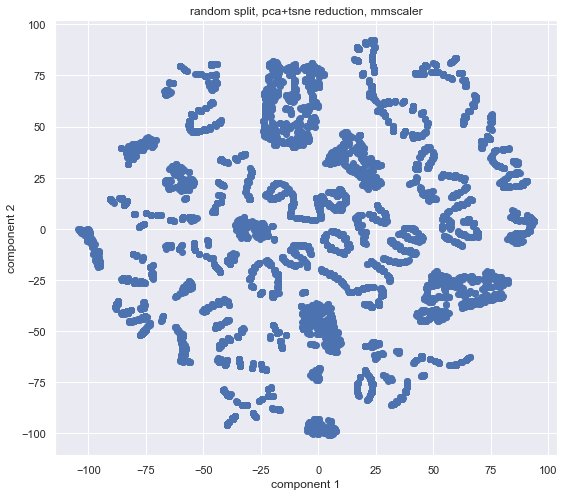

In [152]:
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
import time

def plot_tsne_xtrain(X_train, chunk_size=500, title='Data with reduced dimension (pca + tsne)'):
    """
    Reduces dimensionality of some part of rescaled X_train in Pipeline with 
    PCA and t-SNE and plots it on plane.
    Args:
        X_train: train set 
        chunk_size: number of first rows to plot
    """
        
    X_train_small = X_train[:chunk_size, :]

    pca_tsne = Pipeline([
        ("pca", PCA(n_components=0.95, random_state=0)),
        ("tsne", TSNE(n_components=2, random_state=0)),
    ])
    X_pca_tsne_reduced_train = pca_tsne.fit_transform(X_train_small)
    
    fig = plt.figure(figsize=(8,8))
    plt.scatter(X_pca_tsne_reduced_train[:, 0], X_pca_tsne_reduced_train[:, 1])
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.title(title)
    plt.show();

    
plot_tsne_xtrain(df_random_train_mm, chunk_size=10000, title='random split, pca+tsne reduction, mmscaler')

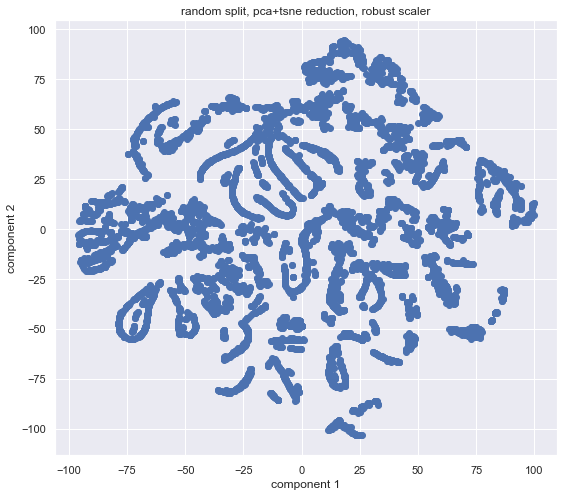

In [153]:
plot_tsne_xtrain(df_random_train_rs, chunk_size=10000, title='random split, pca+tsne reduction, robust scaler')

### 11. Finally, clustering!

#### 11.1 Since we all know that curse of dimmensionality is bad thing, as well as memory errors, let's reduce dimension first

In [154]:
pca_random_mm = PCA(n_components=2)

df_random_train_mm_reduced = pca_random_mm.fit_transform(df_random_train_mm)
df_random_test_mm_reduced = pca_random_mm.transform(df_random_test_mm)

pca_ts_mm = PCA(n_components=2)
df_ts_train_mm_reduced = pca_ts_mm.fit_transform(df_ts_train_mm)
df_ts_test_mm_reduced = pca_ts_mm.transform(df_ts_test_mm)

df_random_train_mm_reduced.shape

(280933, 2)

#### 11.2 K-medoids/means

In [133]:
! pip install sklearn_extra

ERROR: Could not find a version that satisfies the requirement sklearn_extra (from versions: none)
ERROR: No matching distribution found for sklearn_extra
You should consider upgrading via the 'c:\programdata\anaconda3\python.exe -m pip install --upgrade pip' command.


Ok, let's try kmeans

Random split, MinMaxScaler:


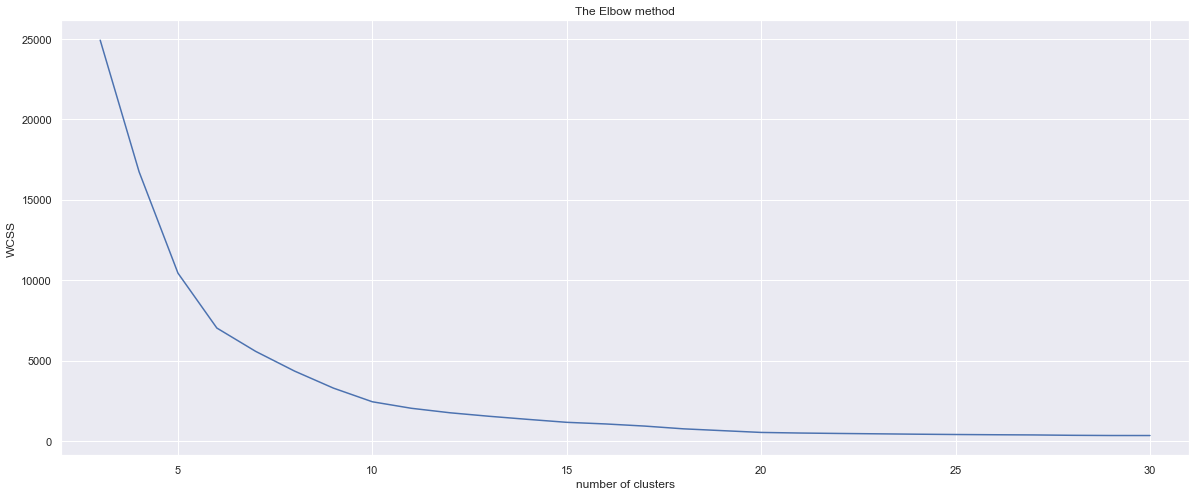

In [155]:
wcss_random_train_mm = []
min_n_clusters = 3
max_n_clusters = 30

print('Random split, MinMaxScaler:')
for n in range(min_n_clusters, max_n_clusters+1):
    kmeans = KMeans(n_clusters = n)
    clusters = kmeans.fit_predict(df_random_train_mm_reduced)
    wcss = kmeans.inertia_
    wcss_random_train_mm.append(wcss)
    # print(f'Number of clusters: {n}, WCSS: {wcss}')

f = plt.figure(figsize=(18,8))
plt.plot(range(min_n_clusters, max_n_clusters+1), wcss_random_train_mm)
plt.xlim((2, max_n_clusters+1))
plt.title("The Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

Let's plot 2-dimensional data together wit cluster centres

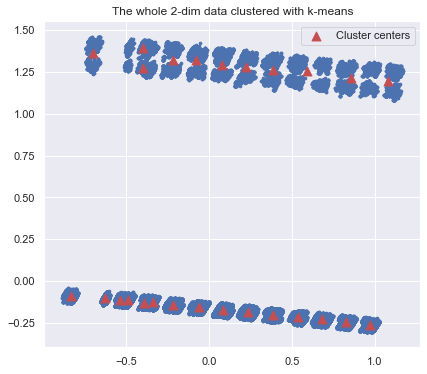

In [162]:
train_labels, test_labels  = cluster_and_plot(df_random_train_mm_reduced, df_random_test_mm_reduced, 26, title='The whole 2-dim data clustered with k-means', plotting=True)

In [177]:
df_random_train['clustering1'] = train_labels
df_random_test['clustering1'] = test_labels

In [183]:
pca = PCA(n_components=2)
mm = MinMaxScaler()

df_mm = mm.fit_transform(df.drop(columns = ['InvoiceNo', 'Description', 'InvoiceDate', 'CustomerID', 'Country']))
df_reduced = pca_random_mm.fit_transform(df_mm)
kmeans = KMeans(n_clusters = 26)
clusters = kmeans.fit_predict(df_reduced)
df['clustering1'] = clusters

### 12. Groupby to get info on each order

#### 12.1 First, prepare the data

In [188]:
df_c = df[['InvoiceNo', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'CustomerID', 'year', 'month', 'dayofweek', 'weekofyear',
       'hour', 'dayofyear', 'is_UK', 'order_cancelled', 'TotalPrice',
       'Basket_Price', 'desc_groups', 'clustering1']]

In [189]:
df_c.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK,order_cancelled,TotalPrice,Basket_Price,desc_groups,clustering1
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,2,48,8,335,1,0,15.30,139.12,0,9
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,2,48,8,335,1,0,20.34,139.12,0,9
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,2010,12,2,48,8,335,1,0,22.00,139.12,0,9
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,2,48,8,335,1,0,20.34,139.12,0,9
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,2,48,8,335,1,0,20.34,139.12,0,9


In [193]:
orders = df_c.groupby('InvoiceNo').mean()[['Quantity', 'UnitPrice', 'year', 'month', 'dayofweek', 'weekofyear',
                                          'hour', 'dayofyear', 'is_UK', 'order_cancelled', 'TotalPrice',
                                          'Basket_Price', 'desc_groups', 'clustering1']]
orders = orders.reset_index()

#### 12.2 Clustering

In [207]:
def plot_with_cluster_centers(centers, data_reduced, n):
    plt.figure(figsize=(6, 6))
    plt.scatter(data_reduced[:,0], data_reduced[:,1], s=7)
    plt.scatter(centers[:,0], centers[:,1], marker='^', c='r', s=80, label=f'{n} cluster centers');
    plt.legend()
    plt.show();

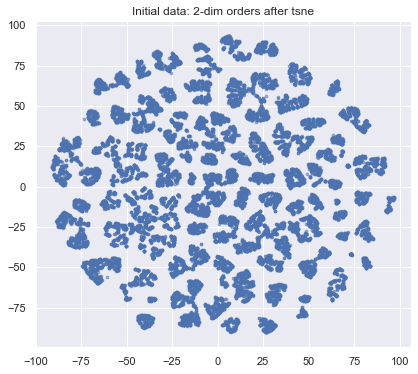

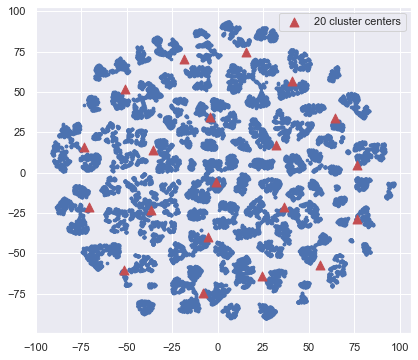

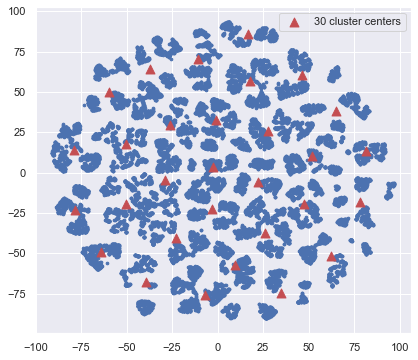

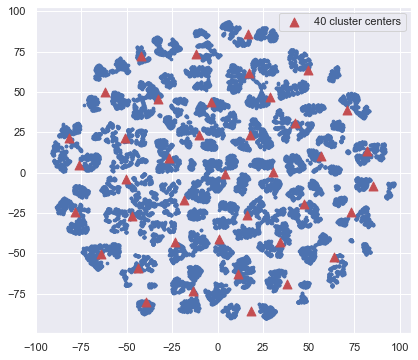

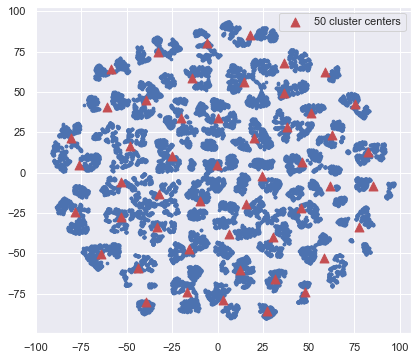

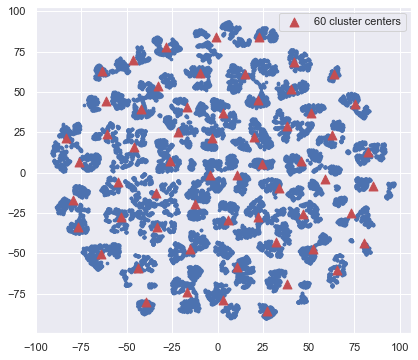

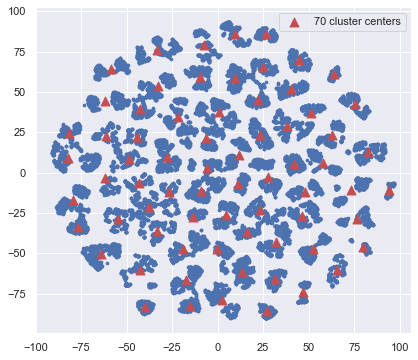

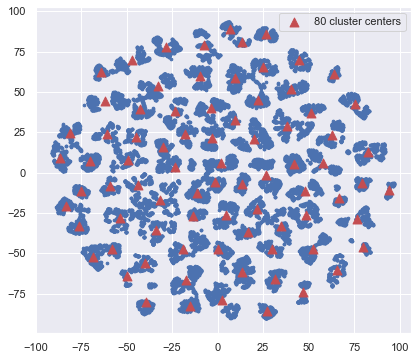

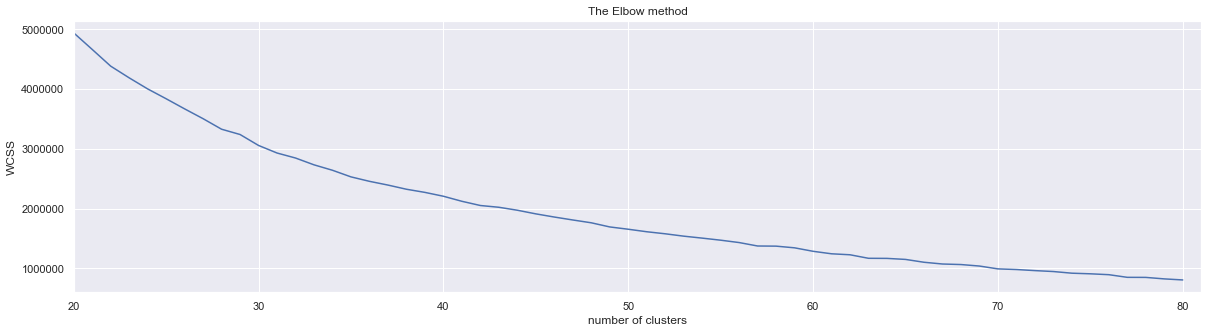

In [211]:
orders_tsne = TSNE(n_components=2)
orders_mm = MinMaxScaler()

orders_rescaled = orders_mm.fit_transform(orders.drop('InvoiceNo', axis=1))
orders_reduced = orders_tsne.fit_transform(orders_rescaled)

plt.figure(figsize=(6,6))
plt.scatter(orders_reduced[:,0], orders_reduced[:,1], s=7, alpha=0.5)
plt.title('Initial data: 2-dim orders after tsne')

wcss_orders = []
min_n_clusters = 20
max_n_clusters = 80

for n in range(min_n_clusters, max_n_clusters+1):
    kmeans = KMeans(n_clusters = n)
    clusters = kmeans.fit_predict(orders_reduced)
    wcss = kmeans.inertia_
    wcss_orders.append(wcss)
    if n % 10 == 0:
        centers = kmeans.cluster_centers_
        plot_with_cluster_centers(centers, orders_reduced, n)

f = plt.figure(figsize=(18,5))
plt.plot(range(min_n_clusters, max_n_clusters+1), wcss_orders)
plt.xlim((min_n_clusters, max_n_clusters+1))
plt.title("The Elbow method")
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show();


Okay, let's pick 85 clusters since it looks best:

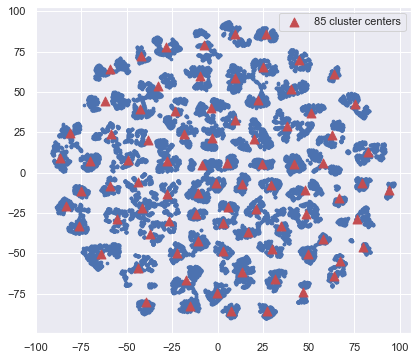

In [213]:
kmeans = KMeans(n_clusters = 85)
clusters = kmeans.fit_predict(orders_reduced)

centers = kmeans.cluster_centers_
plot_with_cluster_centers(centers, orders_reduced, 85)

#### 12.3 Put cluster labels as a new feature

In [214]:
orders['order_cluster'] = clusters

#### 12.4 Now let's also add this new feature *order_cluster* to *df_c* - a dataframe we will use to cluster clients

In [242]:
def get_order_cluster(invoiceno):
    roi = orders[orders.InvoiceNo == invoiceno]
    order_cluster = roi.order_cluster.values[0]
    return order_cluster

df_c['order_cluster'] = df_c.InvoiceNo.apply(lambda invoiceno: get_order_cluster(invoiceno))

### 13. Clustering clients

In [246]:
df_c.head(2)

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,year,month,dayofweek,weekofyear,hour,dayofyear,is_UK,order_cancelled,TotalPrice,Basket_Price,desc_groups,clustering1,order_cluster
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,2010,12,2,48,8,335,1,0,15.30,139.12,0,9,58
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,2010,12,2,48,8,335,1,0,20.34,139.12,0,9,58
